## World value survey data preprocessing for wordalisation

Data from the 7th wave of the World Value Survey (WVS) is used to generate 6 metrics or factors what will be discussed by the chat bot.
This notebook documents the preprocessing steps taken. The data is available at https://www.worldvaluessurvey.org/WVSDocumentationWV7.jsp.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('WVS_Cross-National_Wave_7_csv_v6_0.csv')

C:\Users\Amy\AppData\Local\Temp\ipykernel_32572\429754400.py:1: DtypeWarning: Columns (346,348,350,580,581,582,583) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('WVS_Cross-National_Wave_7_csv_v6_0.csv')


In [3]:
df.head()

,version,doi,A_WAVE,A_YEAR,A_STUDY,B_COUNTRY,B_COUNTRY_ALPHA,C_COW_NUM,C_COW_ALPHA,D_INTERVIEW,...,WVS_Polmistrust_PartyVoter,WVS_LR_MedianVoter,WVS_LibCon_MedianVoter,v2psbars,v2psorgs,v2psprbrch,v2psprlnks,v2psplats,v2xnp_client,v2xps_party
0,6-0-0 (2024-04-30),doi.org/10.14281/18241.24,7,2018,2,20,AND,232,AND,20070001,...,62.434211,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
1,6-0-0 (2024-04-30),doi.org/10.14281/18241.24,7,2018,2,20,AND,232,AND,20070002,...,62.434211,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
2,6-0-0 (2024-04-30),doi.org/10.14281/18241.24,7,2018,2,20,AND,232,AND,20070003,...,62.434211,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
3,6-0-0 (2024-04-30),doi.org/10.14281/18241.24,7,2018,2,20,AND,232,AND,20070004,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6-0-0 (2024-04-30),doi.org/10.14281/18241.24,7,2018,2,20,AND,232,AND,20070005,...,66.964286,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0


In [4]:
df.columns

Index(['version', 'doi', 'A_WAVE', 'A_YEAR', 'A_STUDY', 'B_COUNTRY',
       'B_COUNTRY_ALPHA', 'C_COW_NUM', 'C_COW_ALPHA', 'D_INTERVIEW',
       ...
       'WVS_Polmistrust_PartyVoter', 'WVS_LR_MedianVoter',
       'WVS_LibCon_MedianVoter', 'v2psbars', 'v2psorgs', 'v2psprbrch',
       'v2psprlnks', 'v2psplats', 'v2xnp_client', 'v2xps_party'],
      dtype='object', length=613)

## Constructing the metrics

The six metrics are constructed from several questions from the survey. The questions can be found on the WVS website or in the json file [relevant questions](https://github.com/soccermatics/twelve-gpt-educational/blob/dev/data/wvs/intermediate_data/relevant_questions.json).

Bellow is a dictionary that captures the question number, minimum and maximum values, the 'polarity' and the weight of the question. 

In for example, Q164 is "How important is God in your life?" where "very important" has a high score and is therefore associated with more traditional values (negative polarity). While, Q45 is "In the future, would it be a good thing if we had greater respect for authority?" where "bad" has a higher score and is therefore associate with more secular values (positive polarity). We note that a positive or negative polarity is not a value judgement, but rather a way to distinguish between the two types of values.

The weights are taken from [1] an [2] and were derived using factor analysis. 

[1] Ingelhart, R. and Welzel, C., 2005. Modernization, cultural change, and democracy: The human development sequence.

[2] Allison, L., Wang, C. and Kaminsky, J., 2021. Religiosity, neutrality, fairness, skepticism, and societal tranquility: A data science analysis of the World Values Survey. Plos one, 16(1), p.e0245231.

In [5]:
question_dict = {
    "Traditional vs Secular Values": [ # higher value, more secular
        ("Q164",1,10,-1,0.7),
        ("Q8", 1,2,-1,0.61),
        ("Q14", 1,2,-1,0.61),
        ("Q15", 1,2,1,0.61),
        ("Q17", 1,2,-1,0.61),
        ("Q184", 1,10,1,0.61),
        ("Q254", 1,4,1,0.6), # "I am not [country nationality]" does not express pride or lack of pride
        ("Q45", 1,3,1,0.51),
    ],
    "Survival vs Self-expression Values": [ # higher value, more self-expression
        ("Q3", 1,4,-1,0.59),
        ("Q5", 1,4,1,0.59),
        ("Q40", 1,5,1,0.59),
        ("Q41", 1,5,1,0.59),
        ("Q43", 1,3,1,0.59),
        ("Q131", 1,4,-1,0.59),
        ("Q142", 1,4,1,0.59),
        ("Q150", 1,2,-1,0.59),
        ("Q46",1,4,-1,0.59),
        ("Q49",1,10,1,0.59),
        ("Q22",1,2,1,0.58),
        ("Q182", 1, 10,1,0.58),
        ("Q209",1,3,-1,0.54),
        ("Q218",1,3,-1,0.54),
        ("Q57",1,2,-1,0.44),
        ("Q58",1,4,-1,0.44),
        ("Q59",1,4,-1,0.44),
        ("Q60",1,4,-1,0.44),
        ("Q61",1,4,-1,0.44),
        ("Q62",1,4,-1,0.44),
        ("Q63",1,4,-1,0.44),
    ],
    "Neutrality": [ # higher value, more neutral (less involved in politics/civil society)
        ("Q100", 0,2,-1,0.72),
        ("Q101", 0,2,-1,0.74),
        ("Q102", 0,2,-1,0.76),
        ("Q103", 0,2,-1,0.76),
    ],
    "Fairness": [ # higher means more concerned with fairness/justice
        ("Q179", 1,10,-1,0.77),
        ("Q181", 1,10,-1,0.74),
        ("Q180", 1,10,-1,0.7),
        ("Q191", 1,10,-1,0.63),
        ("Q189", 1,10,-1,0.58),
    ],
    "Skepticism": [ # higher means more skeptical of institutions
        ("Q73", 1,4,1,0.77),
        ("Q71", 1,4,1,0.74),
        ("Q74", 1,4,1,0.7),
        ("Q72", 1,4,1,0.63),
        ("Q70", 1,4,1,0.58),
    ],
    "Societal Tranquility": [ # higher means not concerned about social issues, unrest/war/tourism/access to education
        ("Q143", 1,4,1,0.49),
        ("Q146", 1,4,1,0.8),
        ("Q147", 1,4,1,0.8),
        ("Q148", 1,4,1,0.82),
    ],
    }


We select the ISO 3166-1 alpha-3 country code and the relevant questions from the survey.

In [6]:
cols = ["B_COUNTRY_ALPHA"] #ISO 3166-1 alpha-3 country code
cols+= [q[0] for k in question_dict.keys() for q in question_dict[k]]

df = df[cols]

There are several addition answer codes which we remove from the data.

In [7]:
for key in question_dict.keys():
    for q, min, max, polarity, weight in question_dict[key]:

        # print(df[q].value_counts())

        # replace all values outside of the range with NaN
        df[q] = df[q].apply(lambda x: x if min <= x <= max else None)

In [8]:
df.head()

,B_COUNTRY_ALPHA,Q164,Q8,Q14,Q15,Q17,Q184,Q254,Q45,Q3,...,Q189,Q73,Q71,Q74,Q72,Q70,Q143,Q146,Q147,Q148
0,AND,7.0,1.0,2.0,2.0,1.0,2.0,NaN,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,2.0,4.0,2.0,4.0
1,AND,1.0,2.0,2.0,2.0,1.0,9.0,1.0,1.0,1.0,...,1.0,4.0,4.0,3.0,4.0,3.0,2.0,4.0,4.0,4.0
2,AND,8.0,1.0,1.0,2.0,2.0,5.0,3.0,1.0,2.0,...,1.0,3.0,3.0,3.0,3.0,2.0,4.0,4.0,4.0,4.0
3,AND,1.0,2.0,1.0,2.0,1.0,4.0,NaN,2.0,1.0,...,1.0,3.0,3.0,3.0,3.0,3.0,2.0,3.0,4.0,4.0
4,AND,4.0,2.0,1.0,2.0,2.0,5.0,NaN,2.0,1.0,...,1.0,2.0,2.0,3.0,3.0,2.0,2.0,3.0,2.0,4.0


We now group by country and compute the mean value for each question.

In [9]:
# group by contry and take the mean of the values
df_mean = df.groupby("B_COUNTRY_ALPHA").apply(lambda x: x.mean(skipna=True)).reset_index()

In [10]:
df_mean.head()

,B_COUNTRY_ALPHA,Q164,Q8,Q14,Q15,Q17,Q184,Q254,Q45,Q3,...,Q189,Q73,Q71,Q74,Q72,Q70,Q143,Q146,Q147,Q148
0,AND,4.763052,1.531873,1.636454,1.896414,1.640438,6.074074,1.549266,1.609610,1.421315,...,1.203796,2.763988,2.558233,2.493493,3.042596,2.422805,2.351703,2.878636,2.492972,3.089357
1,ARG,7.148744,1.657029,1.684945,1.793619,1.690927,3.630252,1.529532,1.414195,1.809810,...,1.440321,3.063542,2.935025,3.136223,3.257764,3.121457,2.576799,2.802831,2.769464,2.824847
2,ARM,9.154418,1.808703,1.729885,1.669130,1.791461,2.485762,1.210788,1.235897,1.903146,...,1.246103,3.259510,2.899578,2.757106,3.441998,3.090351,1.805809,1.152334,1.525969,1.540674
3,AUS,4.784761,1.479868,1.555985,1.855488,1.810259,6.562324,1.477907,1.531603,1.646355,...,1.241341,2.813408,2.817372,2.548876,3.118106,2.317851,2.820698,2.631282,2.297599,3.417332
4,BGD,9.660833,1.671667,1.887500,1.150833,1.851667,2.021667,1.186822,1.253785,2.191758,...,1.915000,1.992281,1.890480,2.115695,2.638225,1.989873,1.731064,2.232579,2.224868,2.180357


Of the 66 countries 10 have questions containing missing values.

In [11]:
# show rows where there are NaN values
df_mean[df_mean.isnull().any(axis=1)]

,B_COUNTRY_ALPHA,Q164,Q8,Q14,Q15,Q17,Q184,Q254,Q45,Q3,...,Q189,Q73,Q71,Q74,Q72,Q70,Q143,Q146,Q147,Q148
9,CHN,2.803306,1.219391,1.784249,1.986764,1.944077,2.437231,1.639454,1.568575,2.077965,...,1.553755,1.694904,1.560951,1.882411,1.721339,1.864659,1.909031,2.283824,2.218585,NaN
15,EGY,9.957358,1.855713,1.892410,1.182652,1.442869,2.061603,1.578727,1.310219,2.394449,...,2.550798,3.459514,NaN,3.094607,3.701254,NaN,1.723752,NaN,NaN,NaN
17,GBR,4.095753,1.483482,1.598134,1.918383,1.875632,6.836143,1.855918,1.577118,1.593037,...,NaN,3.018913,3.042347,2.524355,3.125098,2.234894,2.833333,2.283501,2.468883,3.128205
23,IRN,9.337116,1.666444,1.428286,1.454970,1.657105,2.729585,1.219595,1.766644,1.704743,...,1.496998,2.354663,2.584956,2.200938,2.702610,1.983871,2.633705,2.868243,2.740891,3.349057
24,IRQ,NaN,1.862500,1.785000,1.376667,1.434167,2.781667,1.538139,1.253012,1.916178,...,2.615833,3.519264,3.274374,2.916740,3.554878,2.668675,1.808547,1.623225,1.601171,1.760906
27,KAZ,7.660454,1.583072,1.588558,1.848746,1.746865,3.507502,1.592000,1.783737,1.870458,...,2.380912,2.180645,2.114583,2.184505,2.318548,2.230646,1.995912,1.900493,1.845012,NaN
37,MMR,9.705000,1.629167,1.565833,1.474167,1.500000,1.410342,1.166667,2.052500,2.087500,...,1.533778,2.078333,1.898333,2.059167,2.245833,2.419167,1.125833,1.245000,1.128333,1.130833
42,NIR,6.017978,1.523918,1.665148,1.808656,1.783599,4.867580,1.849650,1.587302,1.622472,...,NaN,3.207289,3.163636,2.467442,3.256818,2.275058,2.764310,2.539326,2.695946,2.899772
55,TJK,8.992500,1.652500,1.736667,1.669167,1.713333,2.333333,1.260000,1.359167,2.182500,...,2.296667,1.722764,1.569126,1.875339,2.128440,1.829843,2.442500,2.534167,2.458333,2.596667
62,UZB,8.674361,1.511200,1.666400,1.704000,1.851200,2.889348,1.180772,1.404722,2.231511,...,2.435178,1.956989,1.714866,1.903487,2.148270,1.850734,1.777868,1.762255,1.820179,1.854353


We compute create a separate dataframe for each metric containing the raw answer values, this can be used later to check what a country answered on average.

In [12]:
metric_dfs_raw = []
for key, data in question_dict.items():
    m_cols = ["B_COUNTRY_ALPHA"]
    m_cols += [d[0] for d in data]

    m_df = df_mean[m_cols].copy()
    metric_dfs_raw.append(m_df)
    

In [13]:
metric_dfs_raw[0].head()

,B_COUNTRY_ALPHA,Q164,Q8,Q14,Q15,Q17,Q184,Q254,Q45
0,AND,4.763052,1.531873,1.636454,1.896414,1.640438,6.074074,1.549266,1.609610
1,ARG,7.148744,1.657029,1.684945,1.793619,1.690927,3.630252,1.529532,1.414195
2,ARM,9.154418,1.808703,1.729885,1.669130,1.791461,2.485762,1.210788,1.235897
3,AUS,4.784761,1.479868,1.555985,1.855488,1.810259,6.562324,1.477907,1.531603
4,BGD,9.660833,1.671667,1.887500,1.150833,1.851667,2.021667,1.186822,1.253785


We rescale each metric to a mean of one before computing the metric. The takes into account the differences in the answer scales of the questions. At this point we also multiply by the 'polarity' and weight of the question.

In [14]:
for key in question_dict.keys():
    for q, min, max, polarity, weight in question_dict[key]:
        # rescale to -1,1, taking into account the polarity
        df_mean[q] = df_mean[q].apply(lambda x: polarity*weight*(2*x-(min+max))/(max-min) if x is not None else None)

In [15]:
df_mean.head()

,B_COUNTRY_ALPHA,Q164,Q8,Q14,Q15,Q17,Q184,Q254,Q45,Q3,...,Q189,Q73,Q71,Q74,Q72,Q70,Q143,Q146,Q147,Q148
0,AND,0.114636,-0.038884,-0.166474,0.483625,-0.171335,0.077819,-0.380294,-0.199099,0.424283,...,0.553733,0.135514,0.028728,-0.003036,0.227890,-0.029849,-0.048444,0.201939,-0.003748,0.322182
1,ARG,-0.256471,-0.191575,-0.225633,0.358215,-0.232931,-0.253455,-0.388187,-0.298761,0.271475,...,0.523248,0.289285,0.214613,0.296904,0.318261,0.240297,0.025088,0.161510,0.143714,0.177583
2,ARM,-0.568465,-0.376617,-0.280460,0.206338,-0.355583,-0.408597,-0.515685,-0.389692,0.234763,...,0.548280,0.389882,0.197125,0.119983,0.395639,0.228269,-0.226769,-0.718755,-0.519483,-0.524432
3,AUS,0.111259,0.024562,-0.068301,0.433696,-0.378516,0.144004,-0.408837,-0.238883,0.335767,...,0.548894,0.160883,0.156570,0.022809,0.259604,-0.070431,0.104761,0.070017,-0.107947,0.501475
4,BGD,-0.647241,-0.209433,-0.472750,-0.425983,-0.429033,-0.471507,-0.525271,-0.380570,0.121242,...,0.462067,-0.260629,-0.300696,-0.179342,0.058055,-0.197249,-0.251186,-0.142624,-0.146737,-0.174738


We now compute the scores for each metric by taking the mean over the relevant questions. We also create separate dataframes for each metric so that we can check which question contributed the most to the score.

In [16]:

score_dfs = []
metric_dfs = []
for key, data in question_dict.items():
    m_cols = ["B_COUNTRY_ALPHA"]
    m_cols += [d[0] for d in data]

    m_df = df_mean[m_cols].copy()
    scores_dict = dict(zip(m_df["B_COUNTRY_ALPHA"].values, m_df.iloc[:,1:].mean(axis=1, skipna=True).values))
    scores_df = pd.DataFrame.from_dict(scores_dict, orient='index', columns=[key])
    score_dfs.append(scores_df)
    metric_dfs.append(m_df)
    


In [17]:
metric_dfs[1].head() 

,B_COUNTRY_ALPHA,Q3,Q5,Q40,Q41,Q43,Q131,Q142,Q150,Q46,...,Q182,Q209,Q218,Q57,Q58,Q59,Q60,Q61,Q62,Q63
0,AND,0.424283,-0.383127,-0.077367,0.045135,-0.116703,0.477059,-0.020020,-0.158120,0.310671,...,0.325448,0.191700,-0.020541,-0.214945,0.385950,0.064779,0.224752,-0.129636,0.007563,0.026667
1,ARG,0.271475,-0.405761,-0.111865,-0.112112,0.261881,0.028881,0.009021,-0.159619,0.270692,...,0.067462,-0.053208,-0.195418,-0.257899,0.398681,0.141926,0.163209,-0.109475,0.045970,0.034326
2,ARM,0.234763,-0.454590,-0.051072,-0.247459,0.229117,0.037908,-0.173281,-0.379917,0.319887,...,-0.531933,-0.267680,-0.394409,-0.368649,0.416823,0.088439,0.144007,-0.187709,-0.208820,-0.134903
3,AUS,0.335767,-0.198479,-0.154741,0.134642,-0.095476,0.193387,0.099477,0.075848,0.282089,...,0.243306,0.421969,0.115973,0.035357,0.369353,0.125890,0.265895,-0.004583,0.095760,0.103865
4,BGD,0.121242,-0.502446,-0.451206,-0.374414,0.475071,0.255060,-0.052245,-0.265846,0.261567,...,-0.491389,-0.250158,-0.314439,-0.326239,0.435352,0.205138,0.093491,-0.182720,-0.116116,-0.198838


In [18]:
# merge all the scores into one dataframe
df_scores = pd.concat(score_dfs, axis=1).reset_index(names=["B_COUNTRY_ALPHA"])

In [19]:
df_scores.head()

,B_COUNTRY_ALPHA,Traditional vs Secular Values,Survival vs Self-expression Values,Neutrality,Fairness,Skepticism,Societal Tranquility
0,AND,-0.035001,0.102412,0.660274,0.622053,0.071849,0.117982
1,ARG,-0.186100,0.051123,0.676371,0.563061,0.271872,0.126974
2,ARM,-0.336095,-0.103437,0.656803,0.635473,0.266180,-0.497360
3,AUS,-0.047627,0.150962,0.488510,0.606655,0.105887,0.142076
4,BGD,-0.445224,-0.083317,0.644197,0.577428,-0.175972,-0.178821


## Distribution of the metrics

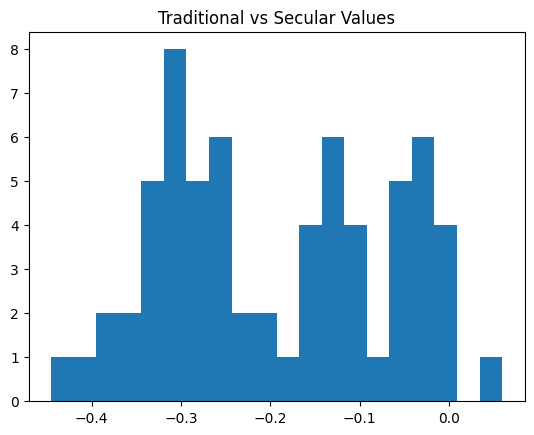

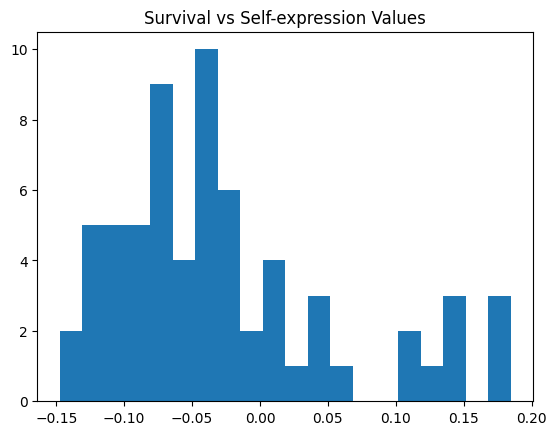

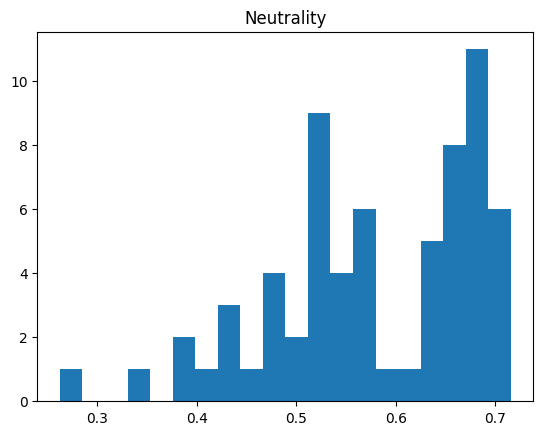

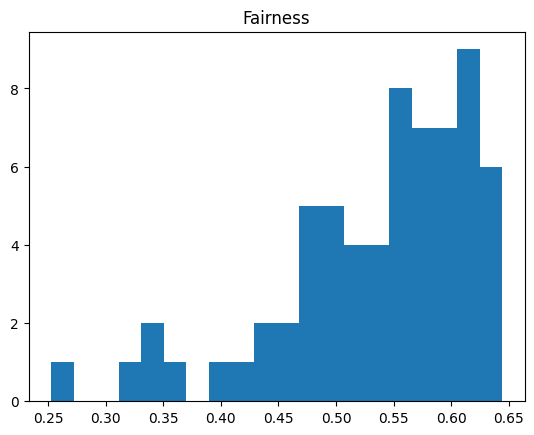

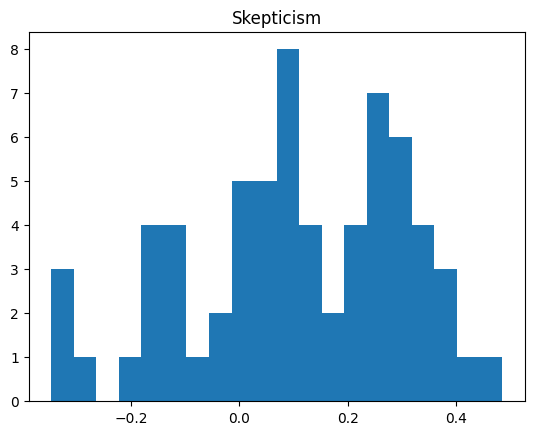

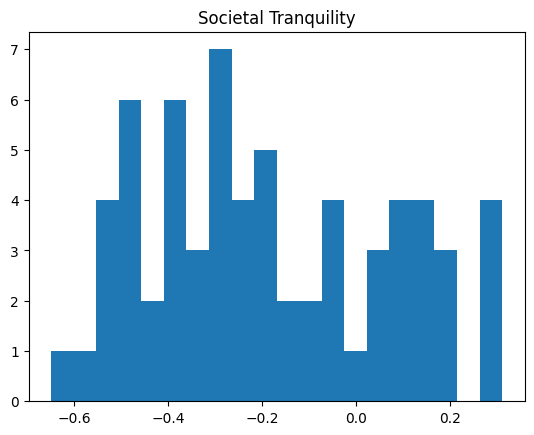

In [20]:
# plot the distribution of the scores

for key in question_dict.keys():
    plt.hist(df_scores[key].values, bins=20)
    plt.title(key)
    plt.show()

## Clean-up

As a final sep we map the country codes to the country names.

In [21]:
country_codes_dict = {
            "AFG": "Afghanistan",
            "ALB": "Albania",
            "DZA": "Algeria",
            "AND": "Andorra",
            "AGO": "Angola",
            "ATG": "Antigua and Barbuda",
            "ARG": "Argentina",
            "ARM": "Armenia",
            "AUS": "Australia",
            "AUT": "Austria",
            "AZE": "Azerbaijan",
            "BHS": "Bahamas",
            "BHR": "Bahrain",
            "BGD": "Bangladesh",
            "BRB": "Barbados",
            "BLR": "Belarus",
            "BEL": "Belgium",
            "BLZ": "Belize",
            "BEN": "Benin",
            "BTN": "Bhutan",
            "BOL": "Bolivia",
            "BIH": "Bosnia and Herzegovina",
            "BWA": "Botswana",
            "BRA": "Brazil",
            "BRN": "Brunei",
            "BGR": "Bulgaria",
            "BFA": "Burkina Faso",
            "BDI": "Burundi",
            "CPV": "Cabo Verde",
            "KHM": "Cambodia",
            "CMR": "Cameroon",
            "CAN": "Canada",
            "CAF": "Central African Republic",
            "TCD": "Chad",
            "CHL": "Chile",
            "CHN": "China",
            "COL": "Colombia",
            "COM": "Comoros",
            "COG": "Congo",
            "CRI": "Costa Rica",
            "HRV": "Croatia",
            "CUB": "Cuba",
            "CYP": "Cyprus",
            "CZE": "Czechia",
            "DNK": "Denmark",
            "DJI": "Djibouti",
            "DMA": "Dominica",
            "DOM": "Dominican Republic",
            "ECU": "Ecuador",
            "EGY": "Egypt",
            "SLV": "El Salvador",
            "GNQ": "Equatorial Guinea",
            "ERI": "Eritrea",
            "EST": "Estonia",
            "SWZ": "Eswatini",
            "ETH": "Ethiopia",
            "FJI": "Fiji",
            "FIN": "Finland",
            "FRA": "France",
            "GAB": "Gabon",
            "GMB": "Gambia",
            "GEO": "Georgia",
            "DEU": "Germany",
            "GHA": "Ghana",
            "GRC": "Greece",
            "GRD": "Grenada",
            "GTM": "Guatemala",
            "GIN": "Guinea",
            "GNB": "Guinea-Bissau",
            "GUY": "Guyana",
            "HTI": "Haiti",
            "HND": "Honduras",
            "HUN": "Hungary",
            "ISL": "Iceland",
            "IND": "India",
            "IDN": "Indonesia",
            "IRN": "Iran",
            "IRQ": "Iraq",
            "IRL": "Ireland",
            "ISR": "Israel",
            "ITA": "Italy",
            "JAM": "Jamaica",
            "JPN": "Japan",
            "JOR": "Jordan",
            "KAZ": "Kazakhstan",
            "KEN": "Kenya",
            "KIR": "Kiribati",
            "PRK": "Korea, North",
            "KOR": "Korea, South",
            "KWT": "Kuwait",
            "KGZ": "Kyrgyzstan",
            "LAO": "Laos",
            "LVA": "Latvia",
            "LBN": "Lebanon",
            "LSO": "Lesotho",
            "LBR": "Liberia",
            "LBY": "Libya",
            "LIE": "Liechtenstein",
            "LTU": "Lithuania",
            "LUX": "Luxembourg",
            "MDG": "Madagascar",
            "MWI": "Malawi",
            "MYS": "Malaysia",
            "MDV": "Maldives",
            "MLI": "Mali",
            "MLT": "Malta",
            "MHL": "Marshall Islands",
            "MRT": "Mauritania",
            "MUS": "Mauritius",
            "MEX": "Mexico",
            "FSM": "Micronesia",
            "MDA": "Moldova",
            "MCO": "Monaco",
            "MNG": "Mongolia",
            "MNE": "Montenegro",
            "MAR": "Morocco",
            "MOZ": "Mozambique",
            "MMR": "Myanmar",
            "NAM": "Namibia",
            "NRU": "Nauru",
            "NPL": "Nepal",
            "NLD": "Netherlands",
            "NZL": "New Zealand",
            "NIC": "Nicaragua",
            "NER": "Niger",
            "NGA": "Nigeria",
            "MKD": "North Macedonia",
            "NOR": "Norway",
            "OMN": "Oman",
            "PAK": "Pakistan",
            "PLW": "Palau",
            "PAN": "Panama",
            "PNG": "Papua New Guinea",
            "PRY": "Paraguay",
            "PER": "Peru",
            "PHL": "Philippines",
            "POL": "Poland",
            "PRT": "Portugal",
            "QAT": "Qatar",
            "ROU": "Romania",
            "RUS": "Russia",
            "RWA": "Rwanda",
            "KNA": "Saint Kitts and Nevis",
            "LCA": "Saint Lucia",
            "VCT": "Saint Vincent and the Grenadines",
            "WSM": "Samoa",
            "SMR": "San Marino",
            "STP": "Sao Tome and Principe",
            "SAU": "Saudi Arabia",
            "SEN": "Senegal",
            "SRB": "Serbia",
            "SYC": "Seychelles",
            "SLE": "Sierra Leone",
            "SGP": "Singapore",
            "SVK": "Slovakia",
            "SVN": "Slovenia",
            "SLB": "Solomon Islands",
            "SOM": "Somalia",
            "ZAF": "South Africa",
            "SSD": "South Sudan",
            "ESP": "Spain",
            "LKA": "Sri Lanka",
            "SDN": "Sudan",
            "SUR": "Suriname",
            "SWE": "Sweden",
            "CHE": "Switzerland",
            "SYR": "Syria",
            "TWN": "Taiwan",
            "TJK": "Tajikistan",
            "TZA": "Tanzania",
            "THA": "Thailand",
            "TLS": "Timor-Leste",
            "TGO": "Togo",
            "TON": "Tonga",
            "TTO": "Trinidad and Tobago",
            "TUN": "Tunisia",
            "TUR": "Turkey",
            "TKM": "Turkmenistan",
            "TUV": "Tuvalu",
            "UGA": "Uganda",
            "UKR": "Ukraine",
            "ARE": "United Arab Emirates",
            "GBR": "United Kingdom",
            "USA": "United States",
            "URY": "Uruguay",
            "UZB": "Uzbekistan",
            "VUT": "Vanuatu",
            "VEN": "Venezuela",
            "VNM": "Vietnam",
            "YEM": "Yemen",
            "ZMB": "Zambia",
            "ZWE": "Zimbabwe",
            "HKG": "Hong Kong",
            "MAC": "Macau",
            "PRI": "Puerto Rico",
            "NIR": "Northern Ireland",
            "GRL": "Greenland",
            "CIV": "Ivory Coast",
            "COD": "Congo, Democratic Republic of the",
            "SWZ": "Eswatini",
        }

In [22]:
# for df in metric_dfs_raw map country codes to country names and rename column to 'country'
for i, df in enumerate(metric_dfs_raw):
    df["B_COUNTRY_ALPHA"] = df["B_COUNTRY_ALPHA"].map(country_codes_dict)
    df.rename(columns={"B_COUNTRY_ALPHA": "country"}, inplace=True)
    metric_dfs_raw[i] = df

# for df in metric_dfs map country codes to country names and rename column to 'country'
for i, df in enumerate(metric_dfs):
    df["B_COUNTRY_ALPHA"] = df["B_COUNTRY_ALPHA"].map(country_codes_dict)
    df.rename(columns={"B_COUNTRY_ALPHA": "country"}, inplace=True)
    metric_dfs[i] = df

# map country codes to country names and rename column to 'country'
df_scores["B_COUNTRY_ALPHA"] = df_scores["B_COUNTRY_ALPHA"].map(country_codes_dict)
df_scores.rename(columns={"B_COUNTRY_ALPHA": "country"}, inplace=True)

In [23]:
metric_dfs_raw[0].head()

,country,Q164,Q8,Q14,Q15,Q17,Q184,Q254,Q45
0,Andorra,4.763052,1.531873,1.636454,1.896414,1.640438,6.074074,1.549266,1.609610
1,Argentina,7.148744,1.657029,1.684945,1.793619,1.690927,3.630252,1.529532,1.414195
2,Armenia,9.154418,1.808703,1.729885,1.669130,1.791461,2.485762,1.210788,1.235897
3,Australia,4.784761,1.479868,1.555985,1.855488,1.810259,6.562324,1.477907,1.531603
4,Bangladesh,9.660833,1.671667,1.887500,1.150833,1.851667,2.021667,1.186822,1.253785


In [24]:
metric_dfs[0].head()

,country,Q164,Q8,Q14,Q15,Q17,Q184,Q254,Q45
0,Andorra,0.114636,-0.038884,-0.166474,0.483625,-0.171335,0.077819,-0.380294,-0.199099
1,Argentina,-0.256471,-0.191575,-0.225633,0.358215,-0.232931,-0.253455,-0.388187,-0.298761
2,Armenia,-0.568465,-0.376617,-0.280460,0.206338,-0.355583,-0.408597,-0.515685,-0.389692
3,Australia,0.111259,0.024562,-0.068301,0.433696,-0.378516,0.144004,-0.408837,-0.238883
4,Bangladesh,-0.647241,-0.209433,-0.472750,-0.425983,-0.429033,-0.471507,-0.525271,-0.380570


In [25]:
df_scores.head()

,country,Traditional vs Secular Values,Survival vs Self-expression Values,Neutrality,Fairness,Skepticism,Societal Tranquility
0,Andorra,-0.035001,0.102412,0.660274,0.622053,0.071849,0.117982
1,Argentina,-0.186100,0.051123,0.676371,0.563061,0.271872,0.126974
2,Armenia,-0.336095,-0.103437,0.656803,0.635473,0.266180,-0.497360
3,Australia,-0.047627,0.150962,0.488510,0.606655,0.105887,0.142076
4,Bangladesh,-0.445224,-0.083317,0.644197,0.577428,-0.175972,-0.178821


## Checking for NaN values

Some countries have missing values for some questions, but importantly the df_scores dataframe does not contain any missing values. This ensures that there is valid data for all countries for all metrics.

In [26]:
# show any nan in the dataframes
for df in metric_dfs_raw:
    print(f"Nans in {len(df[df.isna().any(axis=1)])} rows")
    print(df[df.isna().any(axis=1)])
    print()

Nans in 1 rows
   country  Q164      Q8    Q14       Q15       Q17      Q184      Q254  \
24    Iraq   NaN  1.8625  1.785  1.376667  1.434167  2.781667  1.538139   

         Q45  
24  1.253012  

Nans in 5 rows
       country        Q3        Q5       Q40       Q41       Q43      Q131  \
15       Egypt  2.394449  1.438963  1.410192  1.497051  2.841161  1.541667   
23        Iran  1.704743  1.274431  1.969251  2.670691  2.618023  1.837784   
37     Myanmar  2.087500  1.271667  1.524167  1.689167  2.562500  1.620000   
55  Tajikistan  2.182500  1.568333  1.430833  1.746667  2.407500  1.270833   
62  Uzbekistan  2.231511  1.533280  2.020358  2.250000  1.782681  1.571312   

        Q142      Q150       Q46  ...      Q182      Q209      Q218       Q57  \
15  2.077397  1.872789  2.273561  ...       NaN  2.827468       NaN  1.926483   
23  2.536980  1.850336  2.219773  ...  1.602013  2.341017  2.177224  1.851604   
37  1.891667  1.885833  1.825000  ...  1.721435  2.733738       NaN  1.84916

In [27]:

print(f"Nans in {len(df_scores[df_scores.isna().any(axis=1)])} rows")
print(df_scores[df_scores.isna().any(axis=1)])
print()

Nans in 0 rows
Empty DataFrame
Columns: [country, Traditional vs Secular Values, Survival vs Self-expression Values, Neutrality, Fairness, Skepticism, Societal Tranquility]
Index: []



## Save the data

In [28]:
i = 0
for key in question_dict.keys():
    file_name = "./intermediate_data/" +key + "_raw.csv"
    metric_dfs_raw[i].to_csv(file_name, index=False)

    file_name = "./intermediate_data/" +key + "_pre.csv"
    metric_dfs[i].to_csv(file_name, index=False)

    i += 1

df_scores.to_csv("./wave_7.csv", index=False)
